In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

In [25]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import,
                            index_col='code')

In [26]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 356027 entries, of which we have 22 features.'

# Explore the data

In [27]:
food_facts_pd.head(10)

,created_t,created_datetime,product_name,quantity,packaging,brands,categories,categories_tags,categories_en,origins,...,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000003087,1474103866,2016-09-17T09:17:46Z,Farine de blé noir,1kg,NaN,Ferme t'y R'nao,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000004530,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2243.0,NaN,14,14
0000000004559,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1941.0,NaN,0,0
0000000016087,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2540.0,NaN,12,12
0000000016094,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1552.0,NaN,NaN,NaN
0000000016100,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1933.0,NaN,NaN,NaN
0000000016117,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1490.0,NaN,NaN,NaN
0000000016124,1489055711,2017-03-09T10:35:11Z,Organic Muesli,NaN,NaN,Daddy's Muesli,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1833.0,NaN,7,7
0000000016193,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,NaN,Equal Exchange,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2406.0,NaN,NaN,NaN


## Display number of NaN entries per column

In [ ]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
plt.title("Not null values count in each column")
plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, and a created date tag. Unfortunately, we have to drop all columns, that lack those data. Because our interest lies in the carbon footprint, we have got a dataset of renadom samples from [Eaternity](http://www.eaternity.org/), providing a database for carrying out environmental calculations for menus.

In [ ]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in of our main-features
essential_columns = ['created_t', 'product_name', 'countries_en', 'categories_en', 'manufacturing_places', 'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, of which {} were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, no_rows_reduced_nan-no_rows_reduced_duplicates))
print(data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1]))

Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [ ]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [ ]:
# Next lets look at the data types:
food_facts_pd.dtypes


In [ ]:
#Remove some erros, some created_time have supermarket names instead of time format
food_facts_pd = food_facts_pd[food_facts_pd['created_datetime'].map(len) == 20]
food_facts_pd['created_datetime'] = pd.to_datetime(food_facts_pd['created_datetime'])

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [ ]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [ ]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

The next issue we are going to tackel are redudant columns. Especially here, these are similarly named columns ending with "_en", "_tags". We are handling this, by only importing columns that end with "_en" if we have the choice.

In [ ]:
food_facts_pd

## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

In [ ]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

In [ ]:
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

In [ ]:
#creating Filtered column with right names of countries
copy_purchases_places = food_facts_pd[['purchase_places']]
copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))
copy_purchases_places

In [ ]:
visualize.plot_occurences_of_distinct_values(copy_purchases_places, 'Filtered')

### Labels tags

In [ ]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(lambda x: [labels_lookup[z] for z in x.split(',')])

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [ ]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: [stores_lookup[z] for z in x.split(',')])

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

In [ ]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(lambda x: x.split(','))

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'categories_en')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. The goal afterward is to match Food Facts Database and Carbon Footprint database. First, let's take a look at the Carbon Footprint database.

### Loading the data

In [22]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file,
                            delimiter=",")

In [23]:
carbon_footprint_pd

,ID,Title,Weight [gram/serving],CO2-Value [gram CO2/serving],CO2 rating,FAT,WATER,ENERC,PROT
0,4300175162708,K Classic - Junger Gemüsemais,100,9.0,20.812,3.480252,52.999834,765.655520,8.601195
1,4388840231829,ja! Gemüsemais,100,17.0,37.941,2.312597,35.218431,1070.401621,5.715417
2,8851613101392,Aroy-D - Kokosnussmilch,100,35.0,47.490,25.200000,33.860000,1230.000000,5.340000
3,4003994111000,Kelloggs Cornflakes Die Originalen 375 g,100,29.0,50.203,2.305610,10.145873,1458.792557,7.147392
4,4005009100542,Tortilla Chips Meersalz,100,55.0,53.102,25.168000,5.083000,1918.400000,13.321000
5,4009790005628,Meienburg Sonnenblumenkerne,100,92.0,57.100,53.000000,4.500000,2590.000000,21.300000
6,7610169013310,Migros Engagement Bio Pumpernickel,100,22.0,58.462,1.068827,45.205248,861.348421,5.344133
7,4305399028052,Naturkind - Pumpernickel,100,22.0,58.465,1.054012,44.943116,862.414698,5.318314
8,8690777653008,Sera Ajvar,100,44.0,61.076,11.526800,22.286400,1276.524000,12.058200
9,4009249020240,Lieken Urkorn – Kleines Kerni mit Sonnenblumen...,100,30.0,64.721,5.765991,45.064017,956.863493,6.286967


In [24]:
print('We have {0} ecological features for {1} products.'.format(carbon_footprint_pd.shape[1],carbon_footprint_pd.shape[0]))

We have 9 ecological features for 692 products.


In [ ]:
#pip install py-translate
from translate import translator

In [ ]:
def translate_row(row):
    translation = translator('de', 'en', row)

for i, row in enumerate(carbon_footprint_pd['Title']):
    print(i,row)
    carbon_footprint_pd.loc[i] = translate_row(row)


Text(0,0.5,'Occurencies')

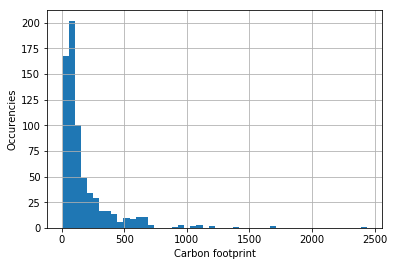

In [42]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

## Remove non-negative entries

In [ ]:
numeric_columns = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] < 0, 0)

# Write clean data frame to CSV file

In [ ]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')